# Learn machine learning models


In [1]:
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd  # version 1.0.3

from sklearn.metrics import brier_score_loss, roc_auc_score,mean_squared_error  # version 0.22.2
from sklearn.model_selection import train_test_split, GridSearchCV  # version 0.22.2
from sklearn.calibration import CalibratedClassifierCV  # version 0.22.2

from scikitplot.metrics import plot_calibration_curve

from xgboost import XGBClassifier  # version 1.0.2

In [3]:
import warnings
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Load dataset

## Load games

In [4]:
df_games = pd.read_hdf('spadl.h5', key='games')

In [5]:
df_games.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
370,2499724,364,181150,2017-08-13 15:00:00,1611,1633
371,2499725,364,181150,2017-08-13 12:30:00,1613,1624
372,2499720,364,181150,2017-08-12 16:30:00,1651,1625
373,2499721,364,181150,2017-08-12 14:00:00,1610,1646
374,2499722,364,181150,2017-08-12 14:00:00,1628,1673
375,2499723,364,181150,2017-08-12 14:00:00,1623,1639
376,2499726,364,181150,2017-08-12 14:00:00,1619,10531
377,2499728,364,181150,2017-08-12 14:00:00,1627,1659
378,2499727,364,181150,2017-08-12 11:30:00,1644,1612
379,2499719,364,181150,2017-08-11 18:45:00,1609,1631


## Load features

Load the *features* for the selected games and combine them into the `df_features` `DataFrame` object.

In [6]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

In [7]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
483655,2499719.0,2.0,2983.268603,1609.0,14869.0,60.90,57.12,84.00,52.36,0,...,0.62,0.70,42.154122,2.933824,37.80,-10.88,58.296128,60.90,-15.64,2499719
483656,2499719.0,2.0,2985.152095,1631.0,8488.0,84.00,52.36,84.00,52.36,0,...,0.54,0.87,54.460220,1.919714,27.30,-6.80,55.358314,27.30,-6.80,2499719
483657,2499719.0,2.0,2985.152095,1631.0,8488.0,84.00,52.36,78.75,48.96,1,...,0.20,0.23,85.983077,4.575163,39.90,41.48,1.883492,34.65,38.08,2499719
483658,2499719.0,2.0,2986.855919,1631.0,265366.0,78.75,48.96,73.50,46.24,0,...,0.80,0.77,27.894257,1.143791,-5.25,-3.40,1.703824,-10.50,-6.12,2499719
483659,2499719.0,2.0,2988.398325,1609.0,7870.0,73.50,46.24,93.45,46.24,0,...,0.25,0.28,80.158369,5.264037,52.50,30.60,3.246230,72.45,30.60,2499719
483660,2499719.0,2.0,2990.768201,1631.0,8653.0,93.45,46.24,97.65,36.04,0,...,0.70,0.68,33.794491,2.573529,14.70,-2.72,3.912282,18.90,-12.92,2499719
483661,2499719.0,2.0,2992.491575,1631.0,8480.0,97.65,36.04,56.70,33.32,0,...,0.11,0.32,94.248184,7.634804,66.15,14.28,4.093250,25.20,11.56,2499719
483662,2499719.0,2.0,2994.900590,1609.0,49876.0,56.70,33.32,76.65,28.56,1,...,0.07,0.47,97.671306,47.867647,45.15,11.56,4.132389,65.10,6.80,2499719
483663,2499719.0,2.0,2997.086392,1609.0,7870.0,76.65,28.56,105.00,27.20,0,...,0.46,0.51,56.704077,83.382353,69.30,-3.40,4.594817,97.65,-4.76,2499719
483664,2499719.0,2.0,3006.647279,1631.0,8480.0,100.00,34.00,0.00,68.00,0,...,0.27,0.58,76.842801,14.090074,51.70,-0.68,11.746689,-48.30,33.32,2499719


## Load labels

Load the *labels* for the selected games and combine them into the `df_labels` `DataFrame` object.

In [8]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']  
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

In [9]:
df_labels.tail(10)

,scores,concedes,game_id
483655,False,False,2499719
483656,False,False,2499719
483657,False,False,2499719
483658,False,False,2499719
483659,False,False,2499719
483660,False,False,2499719
483661,False,False,2499719
483662,False,False,2499719
483663,False,False,2499719
483664,False,False,2499719


# Split dataset

The following cell splits the available data into a training set and test set using the `train_test_split` function.

* **Test set size:** The `test_size` parameter controls the number of examples in the test set. The challenge is to find an appropriate balance between the number of training examples and the number of test examples. Typically, more training examples yield better models, whereas more test examples yield more reliable evaluation metrics.
* **Random state:** The `random_state` parameter sets the *seed* for the random number generator. By setting a *seed*, the train-test split will be the same for each execution of the `train_test_split` function, which is important for reproducing the results and comparing different models.
* **Stratification:** The `stratify` parameter enforces a *stratified* train-test split according to the provided class label. By doing so, the distribution of the provided class label will be the same in the training set and the test set, which can be helpful to obtain a well-calibrated model. Since we will be using two different class labels (i.e., `scores` and `concedes`), we use a concatenation of both class labels for the stratification procedure.

In [10]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

The following cells inspect whether the training set and test set have the same proportion of positive and negative examples for each class.

In [11]:
df_y_train['scores'].mean()

0.01560769863403921

In [12]:
df_y_test['scores'].mean()

0.015609816610498893

In [13]:
df_y_train['concedes'].mean()

0.004789822144829519

In [14]:
df_y_test['concedes'].mean()

0.00479665887898774

# Construct baseline classifiers

The following cell provides a list of features that the machine learning algorithm will consider to train the model.

In [15]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2'
]

The following cell provides a list of class labels for which the machine learning algorithm will train a model.

**Note:** The `concedes` class label has been commented to speed up the execution of the entire notebook.

In [16]:
labels = [
    'scores',
]

## Train classifiers

The following cell trains an XGBoost classifier for each label using *conservative* hyperparamters for the learning algorithm, which will serve as *baseline* models.

In [17]:
%%time
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators=10,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model


Wall time: 3.93 s


## Estimate probabilities

The following cell estimates the probabilities for each label using the trained *baseline* models.

In [18]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [19]:
df_predictions.head(10)

,scores
1259,0.030734
194670,0.031849
328619,0.030734
271648,0.050358
402001,0.050358
357918,0.030734
402699,0.030734
157709,0.030734
113662,0.030734
207848,0.311906


## Evaluate probabilities

### Compute base rate probabilities

The following cell computes the *base rate* or *prior probability* of each class label in the training set. We use the *base rate* as a naive estimate for each example in the test set being true to establish a baseline for the evaluation metrics.

In [20]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
})

In [21]:
df_base_rates.head(10)

,scores
0,0.015608
1,0.015608
2,0.015608
3,0.015608
4,0.015608
5,0.015608
6,0.015608
7,0.015608
8,0.015608
9,0.015608


### Compute Brier score loss for goal scored model

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the base rate predictions.

In [22]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015366150240371317

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [23]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions['scores']
)

0.015082166394997385

### Compute RMSE score loss for goal scored model

The following cell computes the [RMSE score](https://en.wikipedia.org/wiki/Root-mean-square_deviation) for the base rate predictions.

In [24]:
rmse = math.sqrt(mean_squared_error(df_y_test['scores'],df_base_rates['scores'] ))
print(rmse)

0.1239602768646929


The following cell computes the [RMSE score](https://en.wikipedia.org/wiki/Root-mean-square_deviation) for the predictions by the learned model.

In [25]:
rmse = math.sqrt(mean_squared_error(df_y_test['scores'],df_predictions['scores'] ))
print(rmse)

0.12280946868572197


### Plot calibration curve and probability histogram

The following cell creates a plot to show both a calibration curve and a probability histogram.

<AxesSubplot:ylabel='Frequency'>

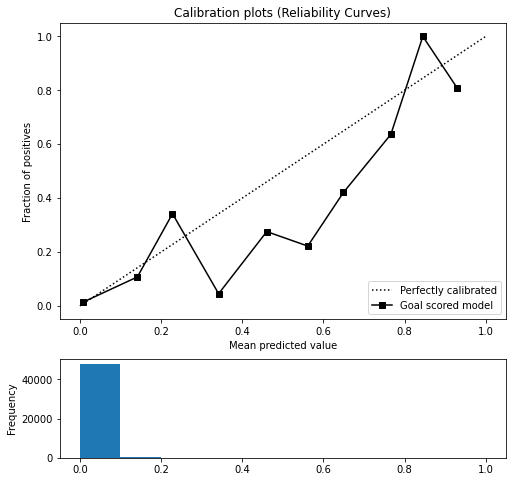

In [26]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)
df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2
)

# Optimize classifiers

In order to train *accurate* models, we perform a *grid search* over different combinations of parameter values for the most important hyperparameters for the learning algorithm. We will focus on the number of estimators and the maximum depth of the decision trees although more hyperparameters influence the performance of the trained models. The more combinations of parameter values need to be explored, the longer the *grid search* will take.

Furthermore, restricting the number of estimators (i.e., the number of decision trees) and the maximum depth of the decision trees is an important mechanism to reduce the complexity of the trained models and thus also to avoid overfitting on the training data. The more decision trees that the learning algorithm can use and the deeper these decision trees can become, the more opportunities the learning algorithm has to *memorize* the training data rather than to discover patterns that generalize to the unseen test data.

## Train classifiers

The following cell trains an XGBoost classifier for each label by trying different combinations of hyperparameters.

In [27]:
%%time
models_cv = {}
for label in tqdm(labels):
    model = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid={
            'n_estimators': [50, 150],
            'max_depth': [3, 5]
        },
        scoring='neg_brier_score',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=1
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=3, n_estimators=50 ....................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ....... max_depth=3, n_estimators=50, score=-0.014, total=   6.1s
[CV] max_depth=3, n_estimators=50 ....................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[CV] ....... max_depth=3, n_estimators=50, score=-0.014, total=   6.5s
[CV] max_depth=3, n_estimators=50 ....................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s
[CV] ....... max_depth=3, n_estimators=50, score=-0.014, total=   5.9s
[CV] max_depth=3, n_estimators=50 ....................................
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.4s remaining:    0.0s
[CV] ....... max_depth=3, n_estimators=50, score=-0.015, total=   6.6s
[CV] max_depth=3, n_estimators=50 .................

**Note:** We have considered a manually selected set of features to represent the game states. In addition to optimizing the hyperparameters for the learning algorithm, we could also optimize the set of features to be considered by the learning algorithm. However, the XGBoost algorithm should be able to figure out by itself which features are most important to include in the model by the nature of the algorithm.

# Construct final classifiers

Once we have found the *best* feature set and *best* hyperparameters for the learning algorithm, we can learn the final model.

1. If we use `GridSearchCV` and the `refit` parameter was set to `True`, we can retrieve the *final* model, which has been re-trained on the entire training set, by accessing the `best_estimator_` attribute of the object.
2. We can manually train the *final* model by creating a `XGBClassifier` object using the *best* hyperparameters and calling the `fit` method with the entire training set.

## Retrieve classifier from grid search

In [28]:
model_scores = models_cv['scores']

The following cell shows the *best* hyperparameter combination that was found using the *grid search*.

In [29]:
pd.Series(
    model_scores.best_params_
)

max_depth        5
n_estimators    50
dtype: int64

The following cell shows the full results of the *grid search*.

In [30]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.230974,0.343081,0.157212,0.017348,3,50,"{'max_depth': 3, 'n_estimators': 50}",-0.014413,-0.014427,-0.014436,-0.014597,-0.014409,-0.014456,0.000071,3
1,16.379438,1.400203,0.186813,0.007871,3,150,"{'max_depth': 3, 'n_estimators': 150}",-0.014378,-0.014373,-0.014384,-0.014539,-0.014380,-0.014411,0.000064,2
2,8.408245,0.623289,0.147670,0.002589,5,50,"{'max_depth': 5, 'n_estimators': 50}",-0.014322,-0.014355,-0.014368,-0.014599,-0.014366,-0.014402,0.000100,1
3,24.634659,1.818527,0.222756,0.024132,5,150,"{'max_depth': 5, 'n_estimators': 150}",-0.014424,-0.014472,-0.014467,-0.014703,-0.014450,-0.014503,0.000101,4


The following cell shows the hyperparameters that were used to re-train the model on the entire training set.

In [31]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
base_score                             0.5
booster                             gbtree
colsample_bylevel                        1
colsample_bynode                         1
colsample_bytree                         1
gamma                                    0
gpu_id                                  -1
importance_type                       gain
interaction_constraints                   
learning_rate                          0.3
max_delta_step                           0
max_depth                                5
min_child_weight                         1
missing                                NaN
monotone_constraints                    ()
n_estimators                            50
n_jobs                                   0
num_parallel_tree                        1
random_state                             0
reg_alpha                                0
reg_lambda                               1
scale_pos_weight                         1
subsample  

The following cell retrieves the final `XGBClassifier` object from the `GridSearchCV` object.

In [32]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
base_score                             0.5
booster                             gbtree
colsample_bylevel                        1
colsample_bynode                         1
colsample_bytree                         1
gamma                                    0
gpu_id                                  -1
importance_type                       gain
interaction_constraints                   
learning_rate                          0.3
max_delta_step                           0
max_depth                                5
min_child_weight                         1
missing                                NaN
monotone_constraints                    ()
n_estimators                            50
n_jobs                                   0
num_parallel_tree                        1
random_state                             0
reg_alpha                                0
reg_lambda                               1
scale_pos_weight                         1
subsample  

In [33]:
model_scores_final = model_scores.best_estimator_

In [34]:
model_scores_final

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Train classifier using optimal hyperparameters

The following cell constructs a new `XGBoostClassifier` object using the *best* hyperparameters that were found by the *grid search*.

In [35]:
model_scores_final = XGBClassifier(
    n_estimators=50,
    max_depth=5
)

The following cell fits the `XGBoostClassifier` object on the entire training set.

In [36]:
model_scores_final.fit(
    X=df_X_train[features],
    y=df_y_train[label]
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
%%time
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators=50,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model


Wall time: 9.26 s


## Evaluate probabilities

In [38]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions_cv, axis=1)

In [39]:
df_predictions.head(10)

,scores
1259,0.030734
194670,0.031849
328619,0.030734
271648,0.050358
402001,0.050358
357918,0.030734
402699,0.030734
157709,0.030734
113662,0.030734
207848,0.311906


### Compute Brier score loss for goal scored model

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the base rate predictions.

In [40]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015366150240371317

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [41]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.01437792617224087

### Compute RMSE score loss for goal scored model

The following cell computes the [RMSE score](https://en.wikipedia.org/wiki/Root-mean-square_deviation) for the base rate predictions.

In [42]:
rmse = math.sqrt(mean_squared_error(df_y_test['scores'],df_base_rates['scores'] ))
print(rmse)

0.1239602768646929


The following cell computes the [RMSE score](https://en.wikipedia.org/wiki/Root-mean-square_deviation) for the predictions by the learned model.

In [43]:
rmse = math.sqrt(mean_squared_error(df_y_test['scores'],df_predictions_cv['scores'] ))
print(rmse)

0.11990799171156093


### Plot calibration curve and probability histogram

The following cell creates a plot to show both a calibration curve and a probability histogram.

<AxesSubplot:ylabel='Frequency'>

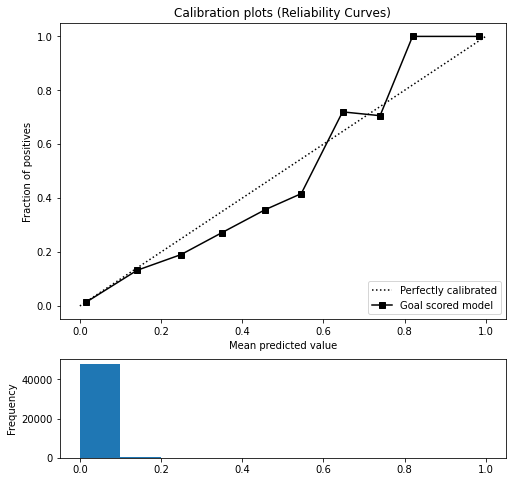

In [44]:
fig_cv, (ax1_cv, ax2_cv) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions_cv['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1_cv
)
df_predictions_cv['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2_cv
)

**References:**
   * Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
   * Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. \"[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)\" *Scientific Data 6*, no. 1 (2019): 1-15."